<a href="https://colab.research.google.com/github/georgezefko/Anomaly-Detection-for-Sequential-Data/blob/branch_updates/AML_VAE_150421.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip3 install pickle5

In [ ]:
import numpy as np
import torch
from torch import nn, optim
from torch import distributions
from torch.utils.data import DataLoader, TensorDataset

from torch.autograd import Variable
import os
import numpy as np
from random import randint
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import copy
from torch.nn.parameter import Parameter
import math
from torch.nn import functional as F
import seaborn as sns
# import pickle5 as pickle

In [ ]:

#Heartbeat data - getting good results
data_train = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/ECG5000/ECG5000_TRAIN', delimiter=',')
data_test_val = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/ECG5000/ECG5000_TEST', delimiter=',')[:-1]

#Gun motion data- very bad results could be due to low amount of data
# data_train = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/GunPointAgeSpan/GunPointAgeSpan_TRAIN.txt')
# data_test_val = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/GunPointAgeSpan/GunPointAgeSpan_TEST.txt')

#Modestrain data- quite good results
# data_train = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/MoteStrain/MoteStrain_TRAIN.txt')
# data_test_val = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/MoteStrain/MoteStrain_TEST.txt')


In [ ]:
data = np.concatenate((data_train, data_test_val), axis=0)


In [ ]:
df = pd.DataFrame(data)
new_columns = list(df.columns)
new_columns[0] = 'target'
df.columns = new_columns
df.target = [int(i) for i in df.target]

In [ ]:
normal_df = df[df.target == 1].drop(labels='target', axis=1)
normal_df.shape

(5546, 140)

In [ ]:
anomaly_df = df[df.target != 1].drop(labels='target', axis=1)
anomaly_df.shape

(3953, 140)

In [ ]:

normal_df = np.expand_dims(normal_df,-1)

anomaly_df = np.expand_dims(anomaly_df,-1)

In [ ]:
# normal = pd.read_csv('/content/drive/MyDrive/AdvancedML/data/normal_df.csv')
# anomaly = pd.read_csv('/content/drive/MyDrive/AdvancedML/data/anomaly_df.csv')

In [ ]:
RANDOM_SEED = 42
train_df, val_df = train_test_split(normal_df,test_size=0.15,random_state=RANDOM_SEED)
val_df, test_df = train_test_split(val_df,test_size=0.33, random_state=RANDOM_SEED)
train_dataset = TensorDataset(torch.from_numpy(train_df).float())
test_dataset = TensorDataset(torch.from_numpy(test_df).float())
val_dataset = TensorDataset(torch.from_numpy(val_df).float())


In [ ]:
seq_len = train_df.shape[1]
n_features = train_df.shape[2]

In [ ]:
cuda = torch.cuda.is_available()

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=cuda)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, pin_memory=cuda)
val_loader  = DataLoader(val_dataset, batch_size=batch_size, pin_memory=cuda)
anomaly_loader = DataLoader(anomaly_dataset, batch_size=batch_size, pin_memory=cuda)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, latent_features, dropout, latent_dim):

    super(Encoder,self).__init__()


    self.seq_len = seq_len
    self.n_features = n_features
    self.latent_dim = latent_dim
    self.hidden_dim = 2 * latent_dim
    self.latent_features = latent_features


    self.rnn1 = nn.GRU( input_size=self.n_features, hidden_size=self.hidden_dim, dropout = dropout, num_layers=1,batch_first=True,bidirectional = True)
    self.rnn2 = nn.GRU( input_size=self.hidden_dim*2, hidden_size= self.latent_dim, dropout = dropout, num_layers=1, batch_first=True, bidirectional = False)
    # self.rnn1 = nn.LSTM( input_size=self.n_features, hidden_size=self.hidden_dim, dropout = dropout, num_layers=1,batch_first=True, bidirectional = True)
    # self.rnn2 = nn.LSTM( input_size=self.hidden_dim, hidden_size= self.latent_dim, dropout = dropout, num_layers=1, batch_first=True, bidirectional = True)

    self.fc = nn.Linear(self.latent_dim, self.hidden_dim )

    self.mu = nn.Linear(self.hidden_dim, self.latent_features)
    self.var = nn.Linear(self.hidden_dim, self.latent_features)


  def forward(self, x):
    
    x = x.to(device)

    out, _ = self.rnn1(x) #GRU

    out, hidden_n = self.rnn2(out) #GRU
    
    hidden = self.fc(hidden_n[-1, :, :]).to(device)

    z_mu = self.mu(hidden)
    z_var = self.var(hidden)

    return z_mu, z_var



In [ ]:

class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim, n_features,dropout):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.GRU(input_size=self.input_dim,hidden_size=self.input_dim, dropout = dropout,num_layers=1,batch_first=True,bidirectional = False)
    self.rnn2 = nn.GRU(input_size=self.input_dim,hidden_size=self.hidden_dim,dropout=dropout,num_layers=1,batch_first=True,bidirectional = True)

    

    self.output_layer = nn.Linear(self.hidden_dim*2 , n_features)

  def forward(self, x):
    
    x = x.unsqueeze(1).repeat(1, self.seq_len, 1)
    x, _ = self.rnn1(x) 
    x, _ = self.rnn2(x) 
    
    x = x.reshape((-1,self.seq_len, self.hidden_dim*2))
    

    return self.output_layer(x)

In [ ]:
class VAE(nn.Module):

  def __init__(self, enc,dec, latent_features,latent_dim,num_samples):

    super(VAE,self).__init__()

  
    self.enc = enc
    self.fc= nn.Linear(latent_features, latent_dim)
    self.dec = dec
    #self.rec = rec
    

  def forward(self, x):

    z_mu, z_var = self.enc(x)

    # Don't propagate gradients through randomness
    with torch.no_grad():
        batch_size = z_mu.size(0)
        epsilon = torch.randn(batch_size, num_samples, latent_features)
            
        if cuda:
          epsilon = epsilon.cuda()


    #reparameterization
    sigma = torch.exp(z_var / 2)
    
    x_sample = z_mu.unsqueeze(1) + epsilon * sigma.unsqueeze(1)
    x_sample = torch.mean(x_sample, dim=1) 

    x = self.fc(x_sample)
    x_hat = self.dec(x)  

    # print('x_dec',x.shape)  

    # x_hat = x.unsqueeze(-1)
    # print('x_unsq',x_hat.shape)
    # x_hat = torch.mean(x_hat, dim=1)
    # print('x_hat_mean',x_hat.shape)

    ##Re-encoder
    mu_rec, var_rec = self.enc(x_hat)



    #reparameterization
    with torch.no_grad():
        batch_size = mu_rec.size(0)
        epsilon = torch.randn(batch_size, num_samples, latent_features)
            
        if cuda:
          epsilon = epsilon.cuda()

    sigma_rec = torch.exp(var_rec / 2)
    
    z_sample = mu_rec.unsqueeze(1) + epsilon * sigma_rec.unsqueeze(1)

    z_sample = torch.mean(z_sample, dim=1)



    return x_hat, z_mu, z_var ,x_sample, mu_rec,var_rec,z_sample 

In [ ]:

latent_features = 10
dropout = 0.2
latent_dim = 64
input_dim = 64
num_samples = 10


# encoder
encoder = Encoder(seq_len, n_features, latent_features, dropout, latent_dim)

# decoder
decoder = Decoder(seq_len, input_dim, n_features,dropout)

#re-encoder
#rencoder = Rencoder(seq_len, n_features, latent_features, dropout, latent_dim)

# vae
model = VAE(encoder,decoder, latent_features ,latent_dim,num_samples).to(device)



print(model)

VAE(
  (enc): Encoder(
    (rnn1): GRU(1, 128, batch_first=True, dropout=0.2, bidirectional=True)
    (rnn2): GRU(256, 64, batch_first=True, dropout=0.2)
    (fc): Linear(in_features=64, out_features=128, bias=True)
    (mu): Linear(in_features=128, out_features=10, bias=True)
    (var): Linear(in_features=128, out_features=10, bias=True)
  )
  (fc): Linear(in_features=10, out_features=64, bias=True)
  (dec): Decoder(
    (rnn1): GRU(64, 64, batch_first=True, dropout=0.2)
    (rnn2): GRU(64, 128, batch_first=True, dropout=0.2, bidirectional=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
def loss(X, x_hat, z_mu, z_var, x_sample, rec_mu, rec_var, z_sample,criterion):

  if criterion == 'MSELoss':
    criterion = nn.MSELoss(size_average=False)
  elif criterion == 'SmoothL1Loss':
    criterion = nn.SmoothL1Loss(size_average=False)

  recon_loss = criterion(x_hat, X)
  latent_loss = criterion(x_sample, z_sample)

  KL_loss = -0.5 * torch.mean(1 + z_var - z_mu**2 - torch.exp(z_var))
  KL_latent = -0.5 * torch.mean(1 + rec_var - rec_mu**2 - torch.exp(rec_var))

  elbo_loss = recon_loss + KL_loss
  total_loss = recon_loss + KL_loss + latent_loss + KL_latent
  return total_loss, elbo_loss, KL_loss

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0006796395231964973) # lr derived from optimazation method



In [ ]:
X= next(iter(train_loader))
x = X[0].to(device)
outputs = model(x.float())


x_hat, z_mu, z_var, x_sample, mu_rec, var_rec, z_sample = outputs

#total_loss, elbo_loss, KL_loss = loss(x, x_hat, z_mu, z_var, x_sample, mu_rec, var_rec, z_sample,criterion='SmoothL1Loss')
print('x',x.shape)
print('mu',z_mu.shape)
print('var',z_var.shape)
print('x_hat',x_hat.shape)
print('x_sample',x_sample.shape)
print('mu_rec',mu_rec.shape)
print('var_Rec',var_rec.shape)
print('z_sample',z_sample.shape)
# print('total',total_loss)
# print('elbo',elbo_loss)
# print('KL',KL_loss)


x torch.Size([32, 140, 1])
mu torch.Size([32, 10])
var torch.Size([32, 10])
x_hat torch.Size([32, 140, 1])
x_sample torch.Size([32, 10])
mu_rec torch.Size([32, 10])
var_Rec torch.Size([32, 10])
z_sample torch.Size([32, 10])


In [ ]:
total_loss, elbo_loss, KL_loss = loss(x, x_hat, z_mu, z_var, x_sample, mu_rec, var_rec, z_sample,criterion='SmoothL1Loss')
print(total_loss)
print(elbo_loss)
print(KL_loss)

tensor(1586.0833, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1554.5867, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0047, device='cuda:0', grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
def train():

  model.train()

  train_loss = []
  train_kl = []
  train_total = []
  

  for t, X in enumerate(train_loader):

    X =X[0]
    X = X.to(device)

    optimizer.zero_grad()

    x_hat, z_mu, z_var, x_sample, rec_mu, rec_var, z_sample = model(X)

    total_loss, elbo_loss, KL_loss = loss(X, x_hat, z_mu, z_var, x_sample, rec_mu, rec_var, z_sample,criterion='SmoothL1Loss')

    total_loss.backward()

    train_loss.append(elbo_loss.item())
    train_kl.append(KL_loss.item())
    train_total.append(total_loss.item())

    optimizer.step()
  
  train_elbo_loss = np.mean(train_loss)
  train_kl_loss = np.mean(train_kl)
  train_total_loss = np.mean(train_total)

  return train_total_loss, train_elbo_loss,train_kl_loss



In [ ]:
def test():

  model.eval()

  with torch.no_grad():
    test_loss = []
    test_kl = []
    test_total = []
    for t, x in enumerate(val_loader):

      x = x[0]
      x = x.to(device)
      x_hat, z_mu, z_var, x_sample, rec_mu, rec_var, z_sample = model(x)
      total_loss, elbo_loss, KL_loss = loss(x, x_hat, z_mu, z_var, x_sample, rec_mu, rec_var, z_sample,criterion='SmoothL1Loss')

      test_loss.append(elbo_loss.item())
      test_kl.append(KL_loss.item())
      test_total.append(total_loss.item())

  test_elbo_loss = np.mean(test_loss)
  test_kl_loss = np.mean(test_kl)
  test_total_loss = np.mean(test_total)

  return model.eval(),test_total_loss, test_elbo_loss,test_kl_loss

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
epochs = 40

best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 10000.0
history_elbo = dict(train_elbo=[], test_elbo=[])
history_kl = dict(train_kl=[], test_kl=[])
history_total = dict(train_total = [], test_total= [])

device = torch.device("cuda:0" if cuda else "cpu")
print("Using device:", device)

for e in range(epochs):

  start_time = time.time()

  train_total_loss, train_elbo_loss, train_kl_loss = train()
  model, test_total_loss, test_elbo_loss, test_kl_loss  = test()

  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if best_loss > test_elbo_loss:
    best_test_loss = test_elbo_loss
    best_model_wts = copy.deepcopy(model.state_dict())

  print(f'Epoch: {e+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\t train total loss {train_total_loss} | train elbo loss {train_elbo_loss} | train kl loss {train_kl_loss}') 
  print(f'\t val total loss {test_total_loss}    | val elbo loss {test_elbo_loss}    | valid kl loss {test_kl_loss}') 


  history_elbo['train_elbo'].append(train_elbo_loss)
  history_elbo['test_elbo'].append(test_elbo_loss)

  history_kl['train_kl'].append(train_kl_loss)
  history_kl['test_kl'].append(test_kl_loss)

  history_total['train_total'].append(train_total_loss)
  history_total['test_total'].append(test_total_loss)


Using device: cuda:0


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 01 | Epoch Time: 0m 6s
	 train total loss 981.8193230500092 | train elbo loss 973.8579988221865 | train kl loss 2.2801993806135363
	 val total loss 911.1586201985677    | val elbo loss 907.1683993869358    | valid kl loss 3.2014354864756265
Epoch: 02 | Epoch Time: 0m 6s
	 train total loss 493.0997950064169 | train elbo loss 487.6638985711175 | train kl loss 2.9245941977243164
	 val total loss 412.4842580159505    | val elbo loss 406.11966196695965    | valid kl loss 2.63447896639506
Epoch: 03 | Epoch Time: 0m 6s
	 train total loss 332.2599173880912 | train elbo loss 327.0743597391489 | train kl loss 2.731043101967992
	 val total loss 293.06951310899524    | val elbo loss 287.6012670728895    | valid kl loss 2.623682737350464
Epoch: 04 | Epoch Time: 0m 6s
	 train total loss 255.70617809811154 | train elbo loss 250.21525382995605 | train kl loss 2.4635719995240906
	 val total loss 254.39396286010742    | val elbo loss 248.37916861640082    | valid kl loss 2.2796724239985147
Epoch:

In [ ]:
# save the model
MODEL_PATH = 'model.pth'
torch.save(model, MODEL_PATH)

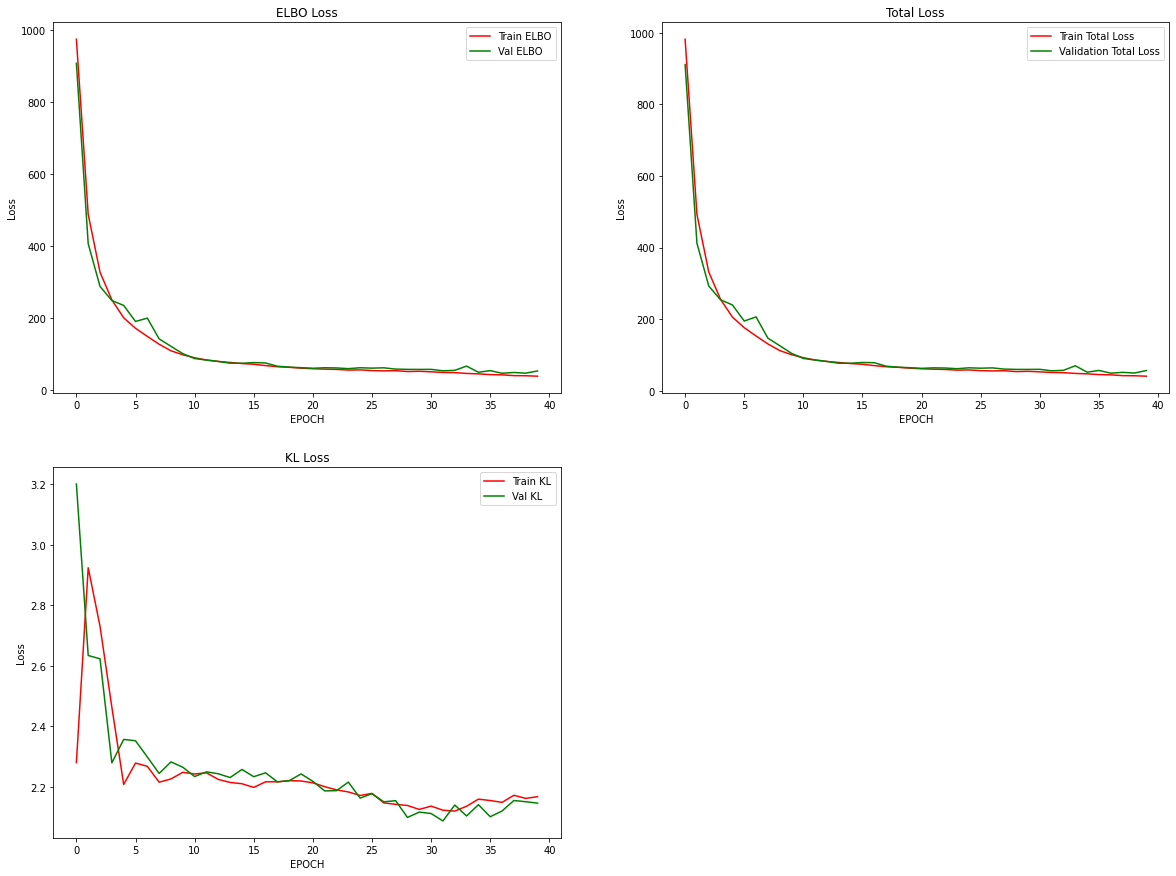

In [ ]:
fig = plt.figure(figsize=(20,15))


fig.add_subplot(2,2,1)
plt.plot(list(range(0,len(history_elbo['train_elbo']))), history_elbo['train_elbo'],'r')
plt.plot(list(range(0,len(history_elbo['test_elbo']))), history_elbo['test_elbo'],'g')
plt.legend(['Train ELBO','Val ELBO'])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title('ELBO Loss')



fig.add_subplot(2,2,2)
plt.plot(list(range(0,len(history_total['train_total']))), history_total['train_total'], 'r')
plt.plot(list(range(0,len(history_total['test_total']))), history_total['test_total'],'g')
plt.legend(['Train Total Loss','Validation Total Loss'])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title('Total Loss')



fig.add_subplot(2,2, 3)
plt.plot(list(range(0,len(history_kl['train_kl']))), history_kl['train_kl'], 'r')
plt.plot(list(range(0,len(history_kl['test_kl']))), history_kl['test_kl'],'g')
plt.legend(['Train KL','Val KL'])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title('KL Loss')





plt.show();



In [ ]:
# def predict(model, dataset):
#   predictions, elbo_losses, total_losses = [], [],[]
#   with torch.no_grad():
#     model = model.eval()
#     for t,x in enumerate(dataset):
#         x = x[0]
#         x = x.to(device)
        
#         x_hat, z_mu, z_var,x_sample, rec_mu, rec_var, z_sample = model(x)
#         total_loss, elbo_loss, KL_loss = loss(x, x_hat, z_mu, z_var, x_sample, rec_mu, rec_var, z_sample,criterion='SmoothL1Loss')
       
#         elbo_losses.append(elbo_loss.item())
#         total_losses.append(total_loss.item())
#         predictions.append(x_hat.cpu().numpy().flatten())
#   return predictions, elbo_losses,total_losses

In [ ]:
def predict(model, dataset):
    predictions = []
    with torch.no_grad():
        model = model.eval()
    for t, X in enumerate(dataset):
        X = X[0]
        x = X.to(device)
        #x = Variable(x, requires_grad = False)
        x_hat, z_mu, z_var,x_sample, rec_mu, rec_var, z_sample = model(x)
        x_hat = x_hat.cpu().detach().numpy()
        x_hat = np.squeeze(x_hat, axis=2)
        predictions.append(x_hat)
    predictions = np.concatenate(predictions, axis=0)
    return predictions

In [ ]:
predict_train = predict(model, train_loader)

In [ ]:
train_original = np.squeeze(train_df,axis=2)

In [ ]:
predict_train.shape

(4714, 140)

In [ ]:
train_original.shape

(4714, 140)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


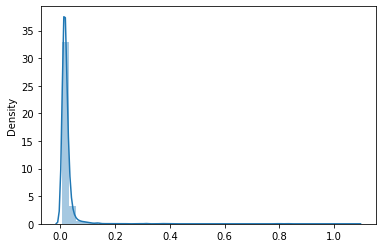

In [ ]:
train_sq_loss = np.mean(( train_original- predict_train)**2, axis=1)
sns.distplot(train_sq_loss, bins=40, kde=True)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


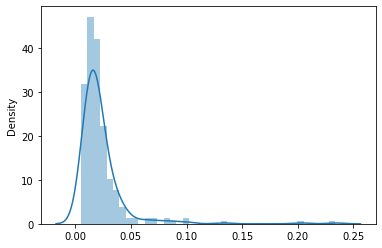

In [ ]:
predict_test = predict(model, test_loader)
test_original = np.squeeze(test_df,axis=2)
test_sq_loss = np.mean(( test_original- predict_test)**2, axis=1)
sns.distplot(test_sq_loss, bins=40, kde=True)
plt.show()

In [ ]:

anomaly_dataset = TensorDataset(torch.from_numpy(anomaly_df).float())
anomaly_loader = DataLoader(anomaly_dataset, batch_size=batch_size, pin_memory=cuda)
predict_anomaly = predict(model, anomaly_loader)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


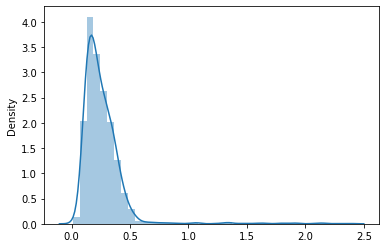

In [ ]:
anomaly_sq_loss = np.mean(( np.squeeze(anomaly_df) - predict_anomaly)**2, axis=1)
sns.distplot(anomaly_sq_loss, bins=40, kde=True)
plt.show()

In [ ]:
threshold_fixed = 0.2

In [ ]:
def plot_prediction(data, reconstructed, title, ax):
  ax.plot(data,'r', label='true')
  ax.plot(reconstructed, 'b',label='reconstructed')
  ax.set_title(f'{title} (Total loss: {np.around(np.mean(( data- reconstructed)**2), 2)})')
  ax.legend()

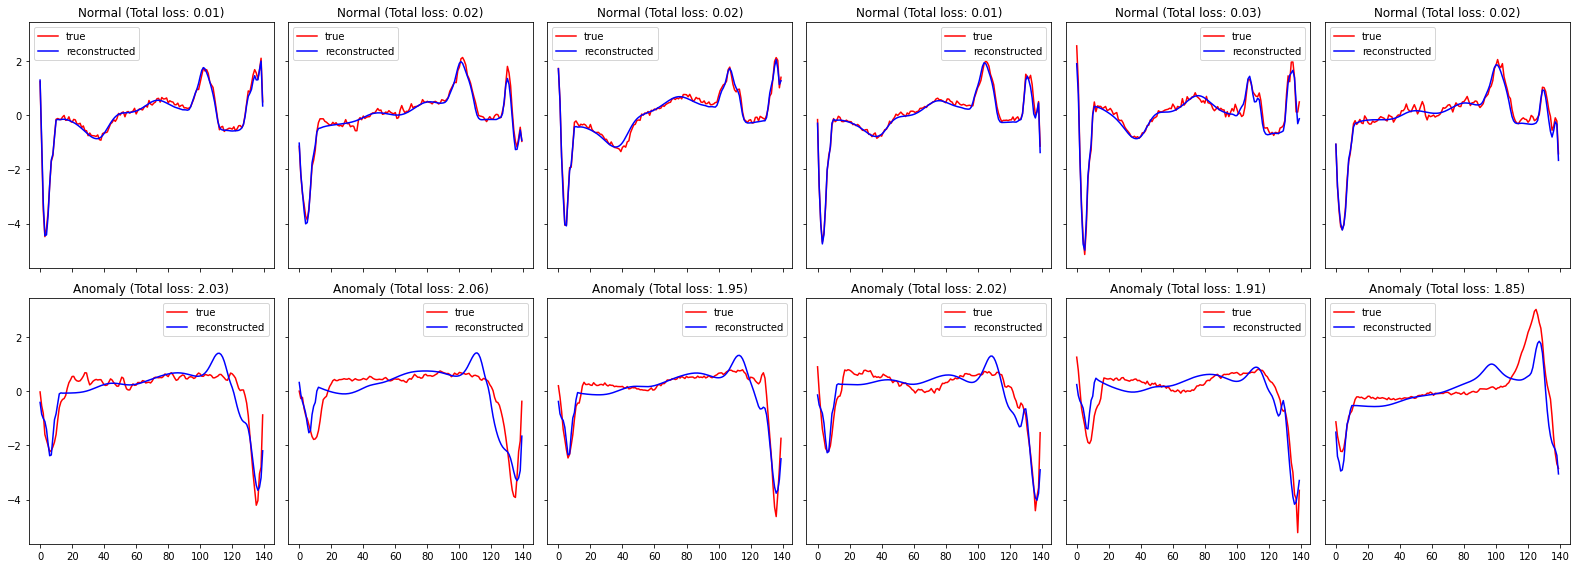

In [ ]:
fig, axs = plt.subplots(nrows=2,ncols=6,sharey=True,sharex=True,figsize=(22, 8))

for i, data in enumerate(test_original[:6]):
  plot_prediction(data, predict_test[i], title='Normal', ax=axs[0, i])

for i, data in enumerate(anomaly_df[:6]):
  plot_prediction(data, predict_anomaly[i], title='Anomaly', ax=axs[1, i])

fig.tight_layout();

In [ ]:
label = np.concatenate((np.ones(len(test_sq_loss)),np.zeros(len(test_sq_loss))))
#total_losses = np.concatenate((train_sq_loss,anomaly_sq_loss),axis=0)
total_losses = np.concatenate((test_sq_loss,np.random.choice(anomaly_sq_loss, len(test_sq_loss),replace=False)),axis=0)
error_df = pd.DataFrame({'Reconstruction_error': total_losses,'Label':label})
#error_df = error_df.sample(frac=1)
error_df.head(2)


,Reconstruction_error,Label
0,0.011432,1.0
1,0.021583,1.0


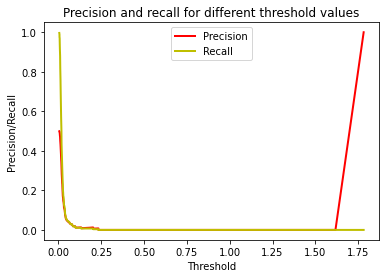

In [ ]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.Label, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:],'r', label="Precision",linewidth=2)
plt.plot(threshold_rt, recall_rt[1:],'y', label="Recall",linewidth=2)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

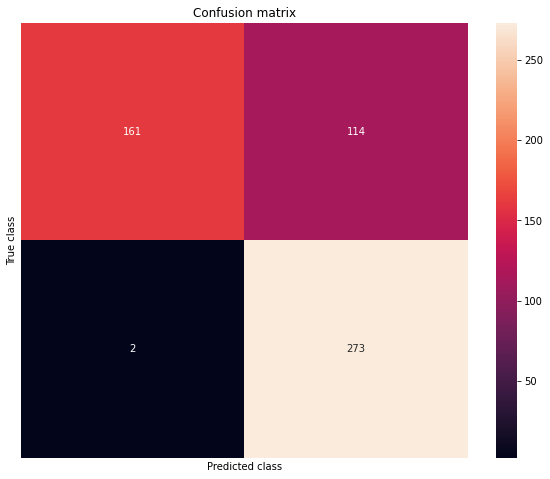

In [ ]:
pred_y = [0 if e > threshold_fixed else 1 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.Label, pred_y)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, xticklabels=[], yticklabels=[], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
